In [ ]:
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/FYP"

/content/drive/MyDrive/FYP


In [ ]:
!unzip "KolektorSDD2 - T4791 - B2085 - D2706.zip" -d "/content"
clear_output()

# SEMANTIC SEGMENTATION ON KOLEKTORSDD2 SURFACE DEFECTS

<table style="position:relative; right:50px;">
    <tr><td colspan="3" rowspan="12"><img src="https://www.vicos.si/resources/kolektorsdd2/images/kolektor-sdd2-types.png" width=350></td></tr>
    <tr><td><b>Benchmark Reference</b></td> 
        <td colspan="2"><a href="https://prints.vicos.si/publications/385">Mixed supervision for surface-defect detection: <br> from weakly to fully supervised learning</a></td></tr>
    <tr><td><b>Number of Classes</b></td> 
        <td>2</td>
        <td><b>Negative</b></td></tr>
    <tr><td></td>
        <td></td>
        <td><b>Positive</b></td></tr>
    <tr><td><b>Number of Samples</b></td>
        <td>3335</td>
        <td><b>356 (Defect)</b></td></tr>
    <tr><td></td>
        <td></td>
        <td><b>2979 (Defect-Free)</b></td></tr>
    <tr><td><b>Image Property</b></td>
        <td>Color</td>
        <td></td></tr>
    <tr><td><b>Image Size</b></td>
        <td>≅ 230 x 630</td>
        <td></td></tr>
</table>

## TABLE OF CONTENTS
0. [CHAPTER 0: IMPORT NECESSARY PYTHON LIBRARIES](#CHAPTER-0:-IMPORT-NECESSARY-PYTHON-LIBRARIES)
1. [CHAPTER 1: DATA PREPARATION](#CHAPTER-1:-DATA-PREPARATION)
2. [CHAPTER 2: DATA PRE-PROCESSING](#CHAPTER-2:-DATA-PRE-PROCESSING)
3. [CHAPTER 3: MODEL CONSTRUCTION](#CHAPTER-3:-MODEL-CONSTRUCTION)
4. [CHAPTER 4: MODEL TRAINING](#CHAPTER-4:-MODEL-TRAINING)
6. [CHAPTER 5: MODEL TESTING](#CHAPTER-5:-MODEL-TESTING)
7. [EXTRA: DEMO](#EXTRA:-DEMO)

## CHAPTER 0: IMPORT NECESSARY PYTHON LIBRARIES

In [ ]:
import os
import cv2
import time
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## CHAPTER 1: DATA PREPARATION

In [ ]:
# set some global parameters
BATCH_SIZE = 5    # Number of training examples utilized in one iteration
IMG_WIDTH = 96    
IMG_HEIGHT = 96
IMG_CHANNELS = 3

TRAIN_IMG_PATH = '/content/KolektorSDD2 - T4791 - B2085 - D2706/train/*'
TRAIN_MASK_PATH = '/content/KolektorSDD2 - T4791 - B2085 - D2706/train/*'
TEST_IMG_PATH = '/content/KolektorSDD2 - T4791 - B2085 - D2706/test/*'
TEST_MASK_PATH = '/content/KolektorSDD2 - T4791 - B2085 - D2706/test/*'

In [ ]:
# get Image and Mask IDs
import glob

TrainImgPaths = []
TrainMaskPaths = []
TestImgPaths = []
TestMaskPaths = []

for name in glob.glob(TRAIN_IMG_PATH):
  if name.endswith("_GT.png"):
    TrainMaskPaths.append(name)
  else:
    TrainImgPaths.append(name)

for name in glob.glob(TEST_IMG_PATH):
  if name.endswith("_GT.png"):
    TestMaskPaths.append(name)
  else:
    TestImgPaths.append(name)

print(len(TrainMaskPaths), len(TrainImgPaths), len(TestMaskPaths), len(TestImgPaths))

4791 4793 1004 1004


In [ ]:
# remove images that dont have corresponding ground truth masks
for name in TrainImgPaths:
  index = name.find('.png')
  if not (name[:index] + '_GT' + name[index:]) in TrainMaskPaths:
    TrainImgPaths.remove(name)

print(len(TrainImgPaths))

4791


In [ ]:
TrainImgPaths.sort()
TrainMaskPaths.sort()
TestImgPaths.sort()
TestMaskPaths.sort()

In [ ]:
# declare four lists to store all the input images and masks
train_images = []
train_masks = []
test_images = []
test_masks = []

In [ ]:
# loop over the image paths
for imagePath in TrainImgPaths:
    # load the image, and resize it to be a fixed pixels, ignoring aspect ratio
    image = cv2.imread(imagePath)
    # set cv2.INTER_AREA as the image resize interpolation method as it typically yields more aesthetically pleasing results
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

    # update the data and labels lists, respectively
    train_images.append(image)

for imagePath in TestImgPaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

    test_images.append(image)

In [ ]:
# loop over the image paths
for maskPath in TrainMaskPaths:
    # load the image, and resize it to be a fixed pixels, ignoring aspect ratio
    mask = cv2.imread(maskPath, 0)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

    # update the data and labels lists, respectively
    train_masks.append(mask)

for maskPath in TestMaskPaths:
    mask = cv2.imread(maskPath, 0)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

    test_masks.append(mask)

## CHAPTER 2: DATA PRE-PROCESSING

In [ ]:
# convert the data into a NumPy array, then preprocess it by scaling all pixel intensities to the range [0, 1]
train_images = np.array(train_images, dtype="float64") / 255.
train_masks = np.array(train_masks, dtype="float64") / 255.
test_images = np.array(test_images, dtype="float64") / 255.
test_masks = np.array(test_masks, dtype="float64") / 255.
print(train_images.shape, train_masks.shape, test_images.shape, test_masks.shape)

(4791, 96, 96, 3) (4791, 96, 96) (1004, 96, 96, 3) (1004, 96, 96)


In [ ]:
# change pixel level masks to boolean type (True / False)
train_compared_mask = np.zeros((train_masks.shape[0], IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
test_compared_mask = np.zeros((test_masks.shape[0], IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

train_masks = train_masks.reshape((train_masks.shape[0], IMG_HEIGHT, IMG_WIDTH, 1))
train_masks = np.maximum(train_masks, train_compared_mask)
train_masks = (train_masks > 0).astype(bool)

test_masks = test_masks.reshape((test_masks.shape[0], IMG_HEIGHT, IMG_WIDTH, 1))
test_masks = np.maximum(test_masks, test_compared_mask)
test_masks = (test_masks > 0).astype(bool)

In [ ]:
# CLASS IMBALANCE
def add_sample_weights(label=train_masks):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tensorflow.constant([1.0, 5.0])
  class_weights = class_weights/tensorflow.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights`
  sample_weights = tensorflow.gather(class_weights, indices=tensorflow.cast(label, tensorflow.int32))

  return sample_weights.numpy()

In [ ]:
# transforming images and labelled masks together
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
seed = 1
# data_gen_args = dict(rotation_range=90,      # rotation
#                      width_shift_range=0.2,  # horizontal shift
#                      height_shift_range=0.2, # vertical shift
#                      zoom_range=[0.5,1.0]    # zoom
#                     )

# train_datagen = ImageDataGenerator(**data_gen_args)
train_datagen = ImageDataGenerator()

# train_datagen.fit(train_images, augment=True, seed=seed)
train_datagen.fit(train_images, augment=False, seed=seed)

train_generator = train_datagen.flow(x=train_images,
                                     y=train_masks,
                                     sample_weight=add_sample_weights(),
                                     batch_size=BATCH_SIZE,
                                     shuffle=True, 
                                     seed=seed)

In [ ]:
# creating the testing Image and Mask generator
test_datagen = ImageDataGenerator()

test_datagen.fit(test_images, augment=False, seed=seed)

test_generator = test_datagen.flow(x=test_images,
                                   y=test_masks,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True, 
                                   seed=seed)

In [ ]:
from tensorflow.keras.utils import array_to_img

def display(display_list):
  plt.figure(figsize=(7, 7))
  
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

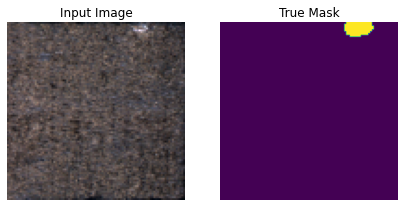

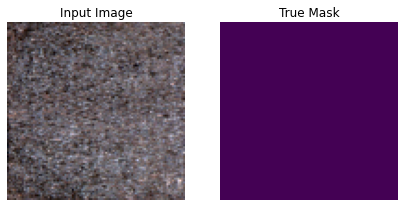

In [ ]:
image, label, weights = next(iter(train_generator))
display([image[0], label[0]])
image, label = next(iter(test_generator))
display([image[2], label[2]])

## CHAPTER 3: MODEL ARCHITECTURE CONSTRUCTION

In [ ]:
!pip install einops
!pip install tensorflow-addons
!pip install --quiet vit-keras
!pip install -q git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 29.0 MB/s 
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import math
import tensorflow_addons as tfa
from einops import rearrange
from tensorflow.image import extract_patches
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Embedding, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, Dropout, Permute, ReLU, Softmax
from tensorflow.keras.layers import Concatenate, Reshape, Add, Multiply
from tensorflow.keras.activations import gelu, relu, softmax, sigmoid
from tensorflow.keras.layers import Flatten, UpSampling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU, BinaryIoU
from keras import backend as K

In [ ]:
# initialize our initial learning rate, number of epochs to train for
INIT_LR = 2e-5
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 50

In [ ]:
def create_mask(pred_mask):
  # pred_mask = tensorflow.argmax(pred_mask, axis=-1)
  # pred_mask = pred_mask[..., tensorflow.newaxis]
  return pred_mask[0]

In [ ]:
# visualize and compare predicted mask output with ground truth mask
def show_predictions(dataset=train_generator):
    image, label, weight = next(iter(dataset))
    pred_mask = model.predict(image)
    pred_mask = tensorflow.cast((pred_mask > 0.5), tensorflow.int64)
    display([image[0], label[0], create_mask(pred_mask)])

In [ ]:
class mean_iou(tensorflow.keras.metrics.MeanIoU):
  def update_state(self, y_true, y_pred, sample_weight=None):
      return super().update_state(y_true, y_pred, sample_weight)

#### Transformer Configuration

In [ ]:
class MultiHeadSelfAttention(tensorflow.keras.layers.Layer):
    def __init__(self, *args, num_heads, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_heads = num_heads

    def build(self, input_shape):
        hidden_size = input_shape[-1]
        num_heads = self.num_heads
        if hidden_size % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {hidden_size} should be divisible by number of heads = {num_heads}"
            )
        self.hidden_size = hidden_size
        self.projection_dim = hidden_size // num_heads
        self.query_dense = tensorflow.keras.layers.Dense(hidden_size, name="query")
        self.key_dense = tensorflow.keras.layers.Dense(hidden_size, name="key")
        self.value_dense = tensorflow.keras.layers.Dense(hidden_size, name="value")
        self.combine_heads = tensorflow.keras.layers.Dense(hidden_size, name="out")

    def attention(self, query, key, value):
        score = tensorflow.matmul(query, key, transpose_b=True)
        dim_key = tensorflow.cast(tensorflow.shape(key)[-1], score.dtype)
        scaled_score = score / tensorflow.math.sqrt(dim_key)
        weights = tensorflow.nn.softmax(scaled_score, axis=-1)
        output = tensorflow.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tensorflow.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tensorflow.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tensorflow.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tensorflow.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tensorflow.reshape(attention, (batch_size, -1, self.hidden_size))
        output = self.combine_heads(concat_attention)
        return output, weights

    def get_config(self):
        config = super().get_config()
        config.update({"num_heads": self.num_heads})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
class TransformerBlock(tensorflow.keras.layers.Layer):
    """Implements a Transformer block."""

    def __init__(self, *args, num_heads, mlp_dim, dropout, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadSelfAttention(
            num_heads=self.num_heads,
            name="MultiHeadDotProductAttention_1",
        )
        self.mlpblock = tensorflow.keras.Sequential(
            [
                tensorflow.keras.layers.Dense(
                    self.mlp_dim,
                    activation="linear",
                    name=f"{self.name}/Dense_0",
                ),
                tensorflow.keras.layers.Lambda(
                    lambda x: tensorflow.keras.activations.gelu(x, approximate=False)
                )
                if hasattr(tensorflow.keras.activations, "gelu")
                else tensorflow.keras.layers.Lambda(
                    lambda x: tensorflow.activations.gelu(x, approximate=False)
                ),
                tensorflow.keras.layers.Dropout(self.dropout),
                tensorflow.keras.layers.Dense(input_shape[-1], name=f"{self.name}/Dense_1"),
                tensorflow.keras.layers.Dropout(self.dropout),
            ],
            name="MlpBlock_3",
        )
        self.layernorm1 = tensorflow.keras.layers.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_0"
        )
        self.layernorm2 = tensorflow.keras.layers.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_2"
        )
        self.dropout_layer = tensorflow.keras.layers.Dropout(self.dropout)

    def call(self, inputs, training):
        x = self.layernorm1(inputs)
        x, weights = self.att(x)
        x = self.dropout_layer(x, training=training)
        x = x + inputs
        y = self.layernorm2(x)
        y = self.mlpblock(y)
        return x + y, weights

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "mlp_dim": self.mlp_dim,
                "dropout": self.dropout,
            }
        )
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
from vit_keras import vit
from vit_keras import visualize
vit = vit.vit_b16(
    image_size = IMG_HEIGHT,
    activation = 'linear',
    pretrained = True,
    include_top = False,
    pretrained_top = False,
    classes = 2)

347512832/347502902 [==============================] - 4s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 6, 6
  UserWarning,


#### Model 1: UNET
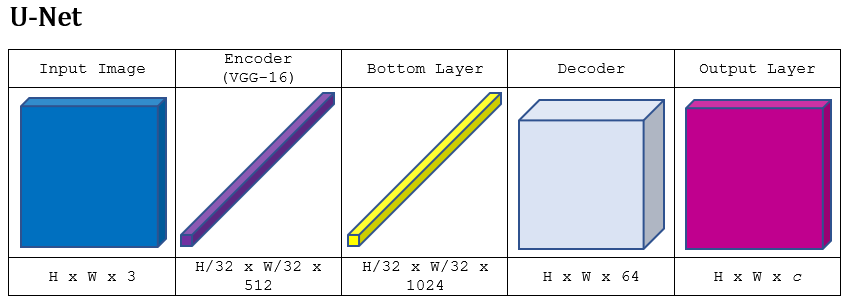

In [ ]:
# contracting part of the architecture
# learn on context information (WHAT)
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
vgg.trainable = False
intermediate = vgg.output

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# expansive part of the architecture
# learn on spatial information (WHERE)
# bottom block and start upsampling
maskHead = Conv2D(1024, (3,3), activation='relu', padding='same')(intermediate)
maskHead = Conv2D(1024, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(512, 3)(maskHead)

# concatenation block 1
maskHead = Concatenate()([vgg.get_layer('block5_conv3').output, maskHead])
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(512, 3)(maskHead)

# concatenation block 2
maskHead = Concatenate()([vgg.get_layer('block4_conv3').output, maskHead])
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(256, 3)(maskHead)

# concatenation block 3
maskHead = Concatenate()([vgg.get_layer('block3_conv3').output, maskHead])
maskHead = Conv2D(256, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(256, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(128, 3)(maskHead)

# concatenation block 4
maskHead = Concatenate()([vgg.get_layer('block2_conv2').output, maskHead])
maskHead = Conv2D(128, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(128, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(64, 3)(maskHead)

# concatenation block 5
maskHead = Concatenate()([vgg.get_layer('block1_conv2').output, maskHead])
maskHead = Conv2D(64, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(64, (3,3), activation='relu', padding='same')(maskHead)

maskHead = Conv2D(1, (1, 1), activation="sigmoid", name="mask")(maskHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
    inputs=vgg.input,
    outputs=maskHead)

#### MODEL 2: DOUBLE U-NET
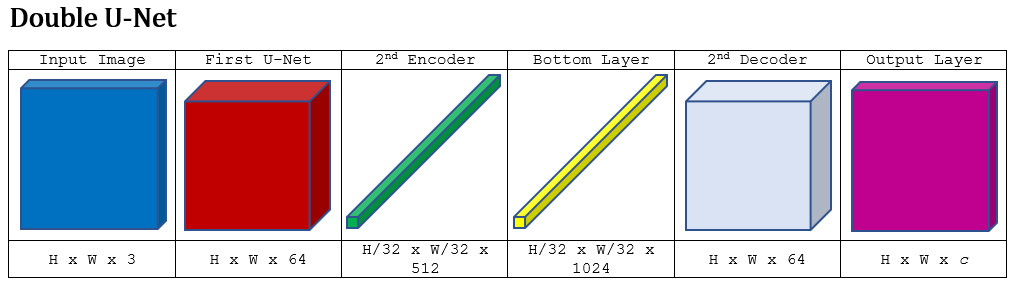

In [ ]:
# load the pretrained UNET network, ensuring the classifier head layers are left off
from tensorflow.keras.models import load_model
UNET = load_model("SEMANTIC_SEGMENTATION_KOLEKTORSDD2_T4791_B2085_D2706_UNET.h5",
                  custom_objects = {"AdamW": tfa.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY),
                                    "mean_iou": mean_iou})
for l in UNET.layers:
    l.trainable = False

In [ ]:
# UNET2 - input
unet_input = UNET.layers[-2].output

# UNET2 - multi-depth dilated inception block 1
# dilated inception block 1: 1st
DILATED_INCEP1_1 = Conv2D(24, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(unet_input)
# dilated inception block 1: 2nd
DILATED_INCEP1_2 = Conv2D(4, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(unet_input)
DILATED_INCEP1_2 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_2)
# dilated inception block 1: 3rd
DILATED_INCEP1_3 = Conv2D(2, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(unet_input)
DILATED_INCEP1_3 = Conv2D(4, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_3)
DILATED_INCEP1_3 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_3)
# dilated inception block 1: 4th
DILATED_INCEP1_4 = Conv2D(4, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(unet_input)
DILATED_INCEP1_4 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
DILATED_INCEP1_4 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
DILATED_INCEP1_4 = Conv2D(24, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
maskDilatedIncepBlock1 = Concatenate()([DILATED_INCEP1_1, DILATED_INCEP1_2, DILATED_INCEP1_3, DILATED_INCEP1_4])
maskHead = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(maskDilatedIncepBlock1)

# UNET2 - multi-depth dilated inception block 2
# dilated inception block 2: 1st
DILATED_INCEP2_1 = Conv2D(48, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
# dilated inception block 2: 2nd
DILATED_INCEP2_2 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP2_2 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_2)
# dilated inception block 2: 3rd
DILATED_INCEP2_3 = Conv2D(4, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP2_3 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_3)
DILATED_INCEP2_3 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_3)
# dilated inception block 2: 4th
DILATED_INCEP2_4 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP2_4 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
DILATED_INCEP2_4 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
DILATED_INCEP2_4 = Conv2D(48, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
maskDilatedIncepBlock2 = Concatenate()([DILATED_INCEP2_1, DILATED_INCEP2_2, DILATED_INCEP2_3, DILATED_INCEP2_4])
maskHead = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(maskDilatedIncepBlock2)

# UNET2 - dilated convolutional block 3
# dilated inception block 3: 1st
DILATED_INCEP3_1 = Conv2D(96, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
# dilated inception block 3: 2nd
DILATED_INCEP3_2 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP3_2 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_2)
# dilated inception block 3: 3rd
DILATED_INCEP3_3 = Conv2D(8, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP3_3 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_3)
DILATED_INCEP3_3 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_3)
# dilated inception block 3: 4th
DILATED_INCEP3_4 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP3_4 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_4)
DILATED_INCEP3_4 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_4)
DILATED_INCEP3_4 = Conv2D(96, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_4)
maskDilatedIncepBlock3 = Concatenate()([DILATED_INCEP3_1, DILATED_INCEP3_2, DILATED_INCEP3_3, DILATED_INCEP3_4])
maskHead = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(maskDilatedIncepBlock3)

# UNET2 - dilated convolutional block 4
# dilated inception block 4: 1st
DILATED_INCEP4_1 = Conv2D(192, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
# dilated inception block 4: 2nd
DILATED_INCEP4_2 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP4_2 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_2)
# dilated inception block 4: 3rd
DILATED_INCEP4_3 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP4_3 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_3)
DILATED_INCEP4_3 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_3)
# dilated inception block 4: 4th
DILATED_INCEP4_4 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP4_4 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_4)
DILATED_INCEP4_4 = Conv2D(128, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_4)
DILATED_INCEP4_4 = Conv2D(192, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_4)
maskDilatedIncepBlock4 = Concatenate()([DILATED_INCEP4_1, DILATED_INCEP4_2, DILATED_INCEP4_3, DILATED_INCEP4_4])
maskHead = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(maskDilatedIncepBlock4)

# UNET2 - dilated convolutional block 5
# dilated inception block 5: 1st
DILATED_INCEP5_1 = Conv2D(192, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
# dilated inception block 5: 2nd
DILATED_INCEP5_2 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP5_2 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_2)
# dilated inception block 5: 3rd
DILATED_INCEP5_3 = Conv2D(16, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP5_3 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_3)
DILATED_INCEP5_3 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_3)
# dilated inception block 5: 4th
DILATED_INCEP5_4 = Conv2D(32, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(maskHead)
DILATED_INCEP5_4 = Conv2D(64, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_4)
DILATED_INCEP5_4 = Conv2D(128, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_4)
DILATED_INCEP5_4 = Conv2D(192, (3, 3), strides = (1, 1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_4)
maskDilatedIncepBlock5 = Concatenate()([DILATED_INCEP5_1, DILATED_INCEP5_2, DILATED_INCEP5_3, DILATED_INCEP5_4])
maskHead = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(maskDilatedIncepBlock5)

# UNET2 - bottom block
maskHead = Conv2D(1024, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2D(1024, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2DTranspose(filters=512, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(maskHead)

# UNET2 - concatenation block 1
maskHead = Concatenate()([maskDilatedIncepBlock5, maskHead])
maskHead = Conv2D(512, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2D(512, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2DTranspose(filters=512, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(maskHead)

# UNET2 - concatenation block 2
maskHead = Concatenate()([maskDilatedIncepBlock4, maskHead])
maskHead = Conv2D(256, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2D(256, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2DTranspose(filters=256, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(maskHead)

# UNET2 - concatenation block 3
maskHead = Concatenate()([maskDilatedIncepBlock3, maskHead])
maskHead = Conv2D(128, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2D(128, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2DTranspose(filters=128, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(maskHead)

# UNET2 - concatenation block 4
maskHead = Concatenate()([maskDilatedIncepBlock2, maskHead])
maskHead = Conv2D(64, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2D(64, (3, 3), padding="same", activation='relu', dilation_rate=2)(maskHead)
maskHead = Conv2DTranspose(filters=64, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(maskHead)

# UNET2 - concatenation block 5
maskHead = Concatenate()([maskDilatedIncepBlock1, maskHead])
maskHead = Conv2D(64, (3, 3), padding="same", activation='relu')(maskHead)
maskHead = Conv2D(64, (3, 3), padding="same", activation='relu')(maskHead)

# finale
final_output = Conv2D(1, (1, 1), activation="sigmoid", name="mask")(maskHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
    inputs=UNET.input,
    outputs=final_output)

#### MODEL 3: SETR
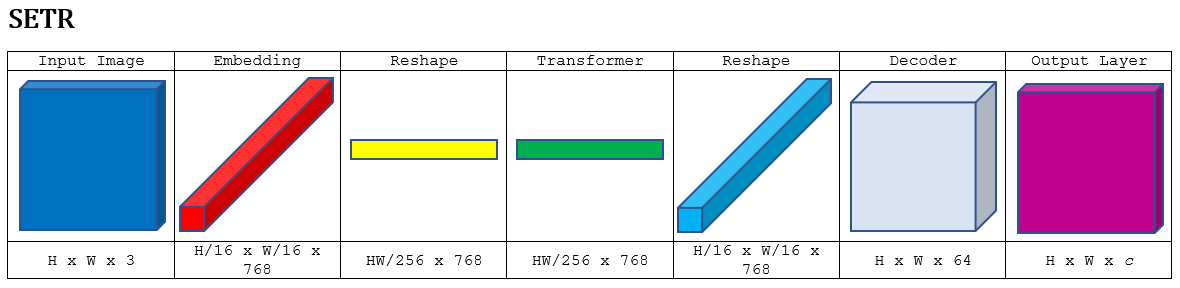

In [ ]:
## SETR TRANSFORMER CONFIG PARAMS
# x = np.random.rand(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
# b, c, h, w = x.shape
patch_size = 16
hidden_size = 768
sample_rate = 4
sample_v = int(math.pow(2, sample_rate))
num_attention_heads = 12
num_hidden_layers = 12
encoder_dense = 3072
dropout_rate = 0.1
hh = IMG_HEIGHT // patch_size 
ww = IMG_WIDTH // patch_size

x = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
b, c, h, w = x.shape

# InputConv2d
embed_layer = Conv2D(filters=hidden_size, kernel_size=patch_size, strides=patch_size, padding="valid", name="embedding")
INPUTDENSE2D_DENSE = embed_layer(x)
embed_layer.set_weights(vit.get_layer("embedding").get_weights())
INPUTDENSE2D_TRANSLAYERNORM = LayerNormalization(epsilon=1e-12, gamma_initializer='ones', beta_initializer='zeros')(INPUTDENSE2D_DENSE)
INPUTDENSE2D_TRANSLAYERNORM = Reshape((INPUTDENSE2D_TRANSLAYERNORM.shape[1] * INPUTDENSE2D_TRANSLAYERNORM.shape[2], hidden_size))(INPUTDENSE2D_TRANSLAYERNORM)

# path_generation = PathGeneration
# inputs = path_generation(patch_size)(x)

# TransEmbeddings
input_shape = INPUTDENSE2D_TRANSLAYERNORM.shape
seq_length = input_shape[1] #36
position_ids = tensorflow.range(seq_length)
position_ids = tensorflow.expand_dims(position_ids, 0)
position_ids = tensorflow.broadcast_to(position_ids, tensorflow.shape(INPUTDENSE2D_TRANSLAYERNORM)[:2])

TRANSEMBEDDINGS_POSITION_EMBEDDINGS = Embedding(512+1, hidden_size, input_length=36, name="PosEmbedLayer")(position_ids)
TRANSEMBEDDINGS_EMBEDDINGS = INPUTDENSE2D_TRANSLAYERNORM + TRANSEMBEDDINGS_POSITION_EMBEDDINGS
TRANSEMBEDDINGS_EMBEDDINGS = LayerNormalization(epsilon=1e-12, gamma_initializer='ones', beta_initializer='zeros', name="EmbedLayerNorm")(TRANSEMBEDDINGS_EMBEDDINGS)
TRANSEMBEDDINGS_EMBEDDINGS = Dropout(0.1, name="EmbedDropLayer")(TRANSEMBEDDINGS_EMBEDDINGS)

# TransEncoder - TransLayer
hidden_states = TRANSEMBEDDINGS_EMBEDDINGS
all_encoder_layers = []
for i in range(12):
   trans_layer = TransformerBlock(
            num_heads=num_attention_heads,
            mlp_dim=encoder_dense,
            dropout=dropout_rate,
            name=f"Transformer/encoderblock_{i}")
   hidden_states, _ = trans_layer(hidden_states)
   trans_layer.set_weights(vit.get_layer(f"Transformer/encoderblock_{i}").get_weights())
ENCODER_FINAL_DENSE = Dense(patch_size * patch_size * hidden_size // (sample_v**2), activation='gelu', name="FinalDenseLayer")(hidden_states)
ENCODER_FINAL_OUTPUT = Reshape((hh*patch_size//sample_v, ww*patch_size//sample_v, hidden_size))(ENCODER_FINAL_DENSE)

# Decoder2D - 1st Decoder
DECODER_1 = Conv2D(512, (3, 3), strides=(1, 1), padding="same", name="DecConvLayer_1")(ENCODER_FINAL_OUTPUT)
DECODER_1 = BatchNormalization(momentum=0.99, epsilon=1e-05, name="DecBatchNorm_1")(DECODER_1)
DECODER_1 = ReLU()(DECODER_1)
DECODER_1 = Conv2DTranspose(filters=512, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(DECODER_1)

# Decoder2D - 2nd Decoder
DECODER_2 = Conv2D(256, (3, 3), strides=(1, 1), padding="same", name="DecConvLayer_2")(DECODER_1)
DECODER_2 = BatchNormalization(momentum=0.99, epsilon=1e-05, name="DecBatchNorm_2")(DECODER_2)
DECODER_2 = ReLU()(DECODER_2)
DECODER_2 = Conv2DTranspose(filters=256, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(DECODER_2)

# Decoder2D - 3rd Decoder
DECODER_3 = Conv2D(128, (3, 3), strides=(1, 1), padding="same", name="DecConvLayer_3")(DECODER_2)
DECODER_3 = BatchNormalization(momentum=0.99, epsilon=1e-05, name="DecBatchNorm_3")(DECODER_3)
DECODER_3 = ReLU()(DECODER_3)
DECODER_3 = Conv2DTranspose(filters=128, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(DECODER_3)

# Decoder2D - 4th Decoder
DECODER_4 = Conv2D(64, (3, 3), strides=(1, 1), padding="same", name="DecConvLayer_4")(DECODER_3)
DECODER_4 = BatchNormalization(momentum=0.99, epsilon=1e-05, name="DecBatchNorm_4")(DECODER_4)
DECODER_4 = ReLU()(DECODER_4)
DECODER_4 = Conv2DTranspose(filters=64, kernel_size=3, strides = (2, 2), activation='relu', padding='same')(DECODER_4)

# FINALE
FINAL_OUTPUT = Conv2D(1, (1, 1), strides=(1, 1), activation="sigmoid", name="mask")(DECODER_4)

model = Model(
    inputs=x,
    outputs=FINAL_OUTPUT)

#### MODEL 4: TRANSUNET
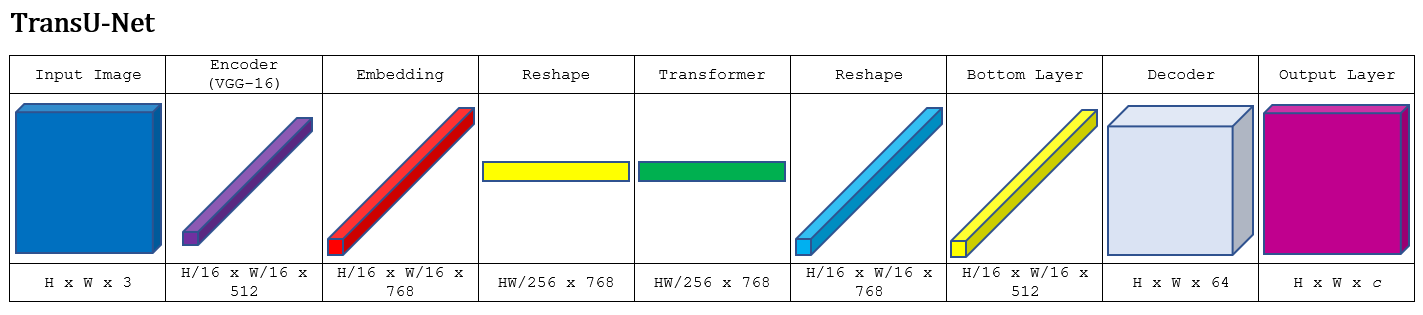

In [ ]:
# contracting part of the architecture
# learn on context information (WHAT)
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
vgg.trainable = False
intermediate = vgg.layers[-2].output

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# trans-encoder part of the architecture
# trans-encoder config params
patch_size = 16
grid = (6,6) 
hidden_size = 768
sample_rate = 4
sample_v = int(math.pow(2, sample_rate))
num_attention_heads = 12
num_hidden_layers = 12
encoder_dense = 3072
dropout_rate = 0.1
hh = IMG_HEIGHT // patch_size
ww = IMG_WIDTH // patch_size

# extract patches from hidden features (shape = [B,H/8*W/8,HIDDEN_SIZE])
cnn_patch_size = IMG_HEIGHT // patch_size // grid[0]
INPUTDENSE2D_DENSE = Conv2D(filters=hidden_size, kernel_size=cnn_patch_size, strides=cnn_patch_size, padding="valid", name="embedding", trainable=True)(intermediate)
INPUTDENSE2D_TRANSLAYERNORM = LayerNormalization(epsilon=1e-12, gamma_initializer='ones', beta_initializer='zeros')(INPUTDENSE2D_DENSE)
INPUTDENSE2D_TRANSLAYERNORM = Reshape((INPUTDENSE2D_TRANSLAYERNORM.shape[1] * INPUTDENSE2D_TRANSLAYERNORM.shape[2], hidden_size))(INPUTDENSE2D_TRANSLAYERNORM)

# position embeddings
input_shape = INPUTDENSE2D_TRANSLAYERNORM.shape
seq_length = input_shape[1]
position_ids = tensorflow.range(seq_length)
position_ids = tensorflow.expand_dims(position_ids, 0)
position_ids = tensorflow.broadcast_to(position_ids, tensorflow.shape(INPUTDENSE2D_TRANSLAYERNORM)[:2])

TRANSEMBEDDINGS_POSITION_EMBEDDINGS = Embedding(512+1, hidden_size, input_length=36, name="PosEmbedLayer")(position_ids)
TRANSEMBEDDINGS_EMBEDDINGS = INPUTDENSE2D_TRANSLAYERNORM + TRANSEMBEDDINGS_POSITION_EMBEDDINGS
TRANSEMBEDDINGS_EMBEDDINGS = LayerNormalization(epsilon=1e-12, gamma_initializer='ones', beta_initializer='zeros', name="EmbedLayerNorm")(TRANSEMBEDDINGS_EMBEDDINGS)
TRANSEMBEDDINGS_EMBEDDINGS = Dropout(0.1, name="EmbedDropLayer")(TRANSEMBEDDINGS_EMBEDDINGS)

# transformer layer
hidden_states = TRANSEMBEDDINGS_EMBEDDINGS
for i in range(num_hidden_layers):
   trans_layer = TransformerBlock(
            num_heads=num_attention_heads,
            mlp_dim=encoder_dense,
            dropout=dropout_rate,
            name=f"Transformer/encoderblock_{i}")
   hidden_states, _ = trans_layer(hidden_states)
   trans_layer.set_weights(vit.get_layer(f"Transformer/encoderblock_{i}").get_weights())
ENCODER_FINAL_DENSE = Dense(patch_size * patch_size * hidden_size // (sample_v**2), activation='gelu', name="FinalDenseLayer")(hidden_states)
ENCODER_FINAL_OUTPUT = Reshape((hh*patch_size//sample_v, ww*patch_size//sample_v, hidden_size))(ENCODER_FINAL_DENSE)

In [ ]:
# expansive part of the architecture
# learn on spatial information (WHERE)
# bottom block and start upsampling
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(ENCODER_FINAL_OUTPUT)
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)

# concatenation block 1
maskHead = Concatenate()([vgg.get_layer('block5_conv3').output, maskHead])
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(512, 3)(maskHead)

# concatenation block 2
maskHead = Concatenate()([vgg.get_layer('block4_conv3').output, maskHead])
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(512, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(256, 3)(maskHead)

# concatenation block 3
maskHead = Concatenate()([vgg.get_layer('block3_conv3').output, maskHead])
maskHead = Conv2D(256, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(256, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(128, 3)(maskHead)

# concatenation block 4
maskHead = Concatenate()([vgg.get_layer('block2_conv2').output, maskHead])
maskHead = Conv2D(128, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(128, (3,3), activation='relu', padding='same')(maskHead)
maskHead = pix2pix.upsample(64, 3)(maskHead)

# concatenation block 5
maskHead = Concatenate()([vgg.get_layer('block1_conv2').output, maskHead])
maskHead = Conv2D(64, (3,3), activation='relu', padding='same')(maskHead)
maskHead = Conv2D(64, (3,3), activation='relu', padding='same')(maskHead)

maskHead = Conv2D(1, (1, 1), activation="sigmoid", name="mask")(maskHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
    inputs=vgg.input,
    outputs=maskHead)

#### MODEL 5: TRANSDAUNET
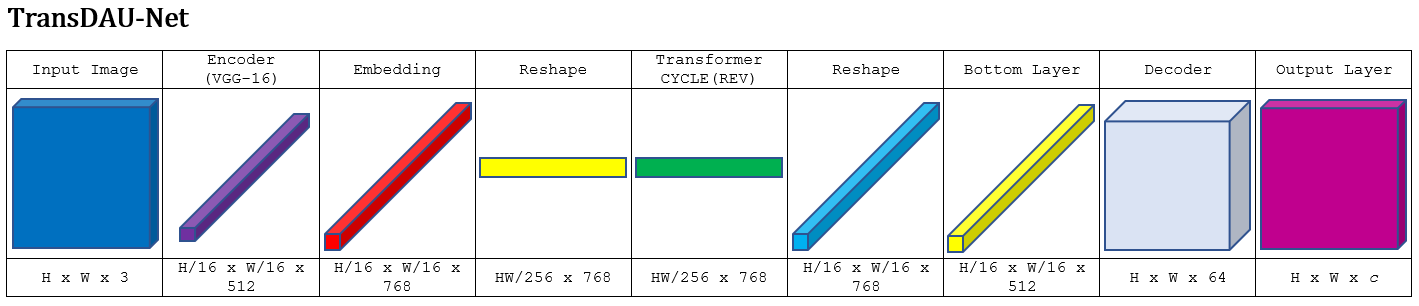

In [ ]:
# contracting part of the architecture
# learn on context information (WHAT)
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
vgg.trainable = False
intermediate = vgg.layers[-2].output

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# trans-encoder part of the architecture
# trans-encoder config params
patch_size = 16
hidden_size = 768
num_attention_heads = 12
num_hidden_layers = 18
encoder_dense = 3072
dropout_rate = 0.1
hh = IMG_HEIGHT // patch_size
ww = IMG_WIDTH // patch_size

# extract patches from hidden features (shape = [B,H/16*W/16,HIDDEN_SIZE])
INPUTDENSE2D_DENSE = Conv2D(filters=hidden_size, kernel_size=1, strides=1, padding="valid", name="embedding", trainable=True)(intermediate)
INPUTDENSE2D_TRANSLAYERNORM = LayerNormalization(epsilon=1e-12, gamma_initializer='ones', beta_initializer='zeros')(INPUTDENSE2D_DENSE)
INPUTDENSE2D_TRANSLAYERNORM = Reshape((INPUTDENSE2D_TRANSLAYERNORM.shape[1] * INPUTDENSE2D_TRANSLAYERNORM.shape[2], hidden_size))(INPUTDENSE2D_TRANSLAYERNORM)

# position embeddings
input_shape = INPUTDENSE2D_TRANSLAYERNORM.shape
seq_length = input_shape[1]
position_ids = tensorflow.range(seq_length)
position_ids = tensorflow.expand_dims(position_ids, 0)
position_ids = tensorflow.broadcast_to(position_ids, tensorflow.shape(INPUTDENSE2D_TRANSLAYERNORM)[:2])

TRANSEMBEDDINGS_POSITION_EMBEDDINGS = Embedding(512+1, hidden_size, input_length=hh*ww, name="PosEmbedLayer")(position_ids)
TRANSEMBEDDINGS_EMBEDDINGS = INPUTDENSE2D_TRANSLAYERNORM + TRANSEMBEDDINGS_POSITION_EMBEDDINGS
TRANSEMBEDDINGS_EMBEDDINGS = LayerNormalization(epsilon=1e-12, gamma_initializer='ones', beta_initializer='zeros', name="EmbedLayerNorm")(TRANSEMBEDDINGS_EMBEDDINGS)
TRANSEMBEDDINGS_EMBEDDINGS = Dropout(dropout_rate, name="EmbedDropLayer")(TRANSEMBEDDINGS_EMBEDDINGS)

# transformer layer
hidden_states = TRANSEMBEDDINGS_EMBEDDINGS
trans_layers = [] 
for i in range(num_hidden_layers//2):
  trans_layers.append(TransformerBlock(
      num_heads=num_attention_heads,
      mlp_dim=encoder_dense,
      dropout=dropout_rate,
      name=f"Transformer/encoderblock_{i}"))
for i in range(num_hidden_layers):
  if (i >= num_hidden_layers//2):
    hidden_states, _ = trans_layers[num_hidden_layers-1-i](hidden_states)
  else:
    hidden_states, _ = trans_layers[i](hidden_states)
    # trans_layers[i].set_weights(vit.get_layer(f"Transformer/encoderblock_{i}").get_weights())
ENCODER_FINAL_DENSE = Dense(hidden_size, activation='gelu', name="FinalDenseLayer")(hidden_states)
ENCODER_FINAL_OUTPUT = Reshape((hh, ww, hidden_size))(ENCODER_FINAL_DENSE)

# bottom block
bottomHead = Conv2D(512, (3,3), activation='relu', padding='same')(ENCODER_FINAL_OUTPUT)
bottomHead = Conv2D(512, (3,3), activation='relu', padding='same', name="BottomBlock")(bottomHead)

In [ ]:
def expend_as(tensor, rep):
    # Anonymous lambda function to expand the specified axis by a factor of argument, rep.
    # If tensor has shape (512,512,N), lambda will return a tensor of shape (512,512,N*rep), if specified axis=2
    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)
    return my_repeat

In [ ]:
def AttentionNode(x, g, num_channels):
    """Implements an attention module."""
    # vector x is taken from the corresponding downsampling layer in the encoder path
    # vector g is taken from the next lowest layer of the network
    x_shape = x.shape
    g_shape = g.shape

    if (x_shape[1] != g_shape[1] | x_shape[2] != g_shape[2]):
      # Getting the gating signal to the same number of filters as the num_channels
      phi_g = Conv2D(filters=num_channels, kernel_size=1, strides=(1,1), padding='valid')(g)
      # Getting the x signal to the same shape as the gating signal
      theta_x = Conv2D(filters=num_channels, kernel_size=1, strides=(2,2), padding='valid')(x)
    else:
      phi_g = Conv2D(filters=num_channels, kernel_size=1, strides=(1,1), padding='valid')(g)
      theta_x = Conv2D(filters=num_channels, kernel_size=1, strides=(1,1), padding='valid')(x)

    # Element-wise addition of the gating and x signals
    add_xg = Add()([phi_g, theta_x])
    add_xg = ReLU()(add_xg)

    # 1x1x1 convolution
    psi = Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = sigmoid(psi)

    if (x_shape[1] != g_shape[1] | x_shape[2] != g_shape[2]):
      # Upsampling psi back to the original dimensions of x signal
      upsample_sigmoid_xg = UpSampling2D(size=(2,2))(psi)
    else:
      upsample_sigmoid_xg = psi

    # Expanding the filter axis to the number of filters in the original x signal
    upsample_sigmoid_xg = expend_as(upsample_sigmoid_xg, x_shape[3])

    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = Multiply()([upsample_sigmoid_xg, x])

    # Final 1x1x1 convolution to consolidate attention signal to original x dimensions
    output = Conv2D(filters=x_shape[3]//2, kernel_size=1, strides=1, padding='same')(attn_coefficients)
    output = BatchNormalization()(output)
    return output

In [ ]:
# expansive part of the architecture
# learn on spatial information (WHERE)
# introducing dilated convolutions and soft attention modules into the skip connections
# skip connection 1
# multi-depth dilated inception block 1
# dilated inception block 1: 1st
DILATED_INCEP1_1 = Conv2D(192, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block5_conv3').output)
# dilated inception block 1: 2nd
DILATED_INCEP1_2 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block5_conv3').output)
DILATED_INCEP1_2 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_2)
# dilated inception block 1: 3rd
DILATED_INCEP1_3 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block5_conv3').output)
DILATED_INCEP1_3 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_3)
DILATED_INCEP1_3 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_3)
# dilated inception block 1: 4th
DILATED_INCEP1_4 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block5_conv3').output)
DILATED_INCEP1_4 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
DILATED_INCEP1_4 = Conv2D(128, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
DILATED_INCEP1_4 = Conv2D(192, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP1_4)
DILATED_1 = Concatenate()([DILATED_INCEP1_1, DILATED_INCEP1_2, DILATED_INCEP1_3, DILATED_INCEP1_4])
# attention modules 1
NON_DILATED_1 = AttentionNode(vgg.get_layer('block5_conv3').output, bottomHead, 512)
DILATED_1 = AttentionNode(DILATED_1, bottomHead, 512)
FIRST_CONN = Concatenate()([NON_DILATED_1, DILATED_1])
# concatenation block 1
FIRST_CONN_BLOCK = pix2pix.upsample(512, 3)(bottomHead)
FIRST_CONN_BLOCK = Concatenate()([FIRST_CONN, bottomHead])
FIRST_CONN_BLOCK = Conv2D(512, (3,3), activation='relu', padding='same')(FIRST_CONN_BLOCK)
FIRST_CONN_BLOCK = Conv2D(512, (3,3), activation='relu', padding='same')(FIRST_CONN_BLOCK)

In [ ]:
# skip connection 2
# multi-depth dilated inception block 2
# dilated inception block 2: 1st
DILATED_INCEP2_1 = Conv2D(192, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block4_conv3').output)
# dilated inception block 2: 2nd
DILATED_INCEP2_2 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block4_conv3').output)
DILATED_INCEP2_2 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_2)
# dilated inception block 2: 3rd
DILATED_INCEP2_3 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block4_conv3').output)
DILATED_INCEP2_3 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_3)
DILATED_INCEP2_3 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_3)
# dilated inception block 2: 4th
DILATED_INCEP2_4 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block4_conv3').output)
DILATED_INCEP2_4 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
DILATED_INCEP2_4 = Conv2D(128, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
DILATED_INCEP2_4 = Conv2D(192, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP2_4)
DILATED_2 = Concatenate()([DILATED_INCEP2_1, DILATED_INCEP2_2, DILATED_INCEP2_3, DILATED_INCEP2_4])
# attention modules 2
NON_DILATED_2 = AttentionNode(vgg.get_layer('block4_conv3').output, FIRST_CONN_BLOCK, 512)
DILATED_2 = AttentionNode(DILATED_2, FIRST_CONN_BLOCK, 512)
SECOND_CONN = Concatenate()([NON_DILATED_2, DILATED_2])
# concatenation block 2
SECOND_CONN_BLOCK = pix2pix.upsample(512, 3)(FIRST_CONN_BLOCK)
SECOND_CONN_BLOCK = Concatenate()([SECOND_CONN, SECOND_CONN_BLOCK])
SECOND_CONN_BLOCK = Conv2D(512, (3,3), activation='relu', padding='same')(SECOND_CONN_BLOCK)
SECOND_CONN_BLOCK = Conv2D(512, (3,3), activation='relu', padding='same')(SECOND_CONN_BLOCK)

In [ ]:
# skip connection 3
# multi-depth dilated inception block 3
# dilated inception block 3: 1st
DILATED_INCEP3_1 = Conv2D(96, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block3_conv3').output)
# dilated inception block 3: 2nd
DILATED_INCEP3_2 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block3_conv3').output)
DILATED_INCEP3_2 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_2)
# dilated inception block 3: 3rd
DILATED_INCEP3_3 = Conv2D(8, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block3_conv3').output)
DILATED_INCEP3_3 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_3)
DILATED_INCEP3_3 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_3)
# dilated inception block 3: 4th
DILATED_INCEP3_4 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block3_conv3').output)
DILATED_INCEP3_4 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_4)
DILATED_INCEP3_4 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_4)
DILATED_INCEP3_4 = Conv2D(96, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP3_4)
DILATED_3 = Concatenate()([DILATED_INCEP3_1, DILATED_INCEP3_2, DILATED_INCEP3_3, DILATED_INCEP3_4])
# attention modules 3
NON_DILATED_3 = AttentionNode(vgg.get_layer('block3_conv3').output, SECOND_CONN_BLOCK, 256)
DILATED_3 = AttentionNode(DILATED_3, SECOND_CONN_BLOCK, 256)
THIRD_CONN = Concatenate()([NON_DILATED_3, DILATED_3])
# concatenation block 3
THIRD_CONN_BLOCK = pix2pix.upsample(256, 3)(SECOND_CONN_BLOCK)
THIRD_CONN_BLOCK = Concatenate()([THIRD_CONN, THIRD_CONN_BLOCK])
THIRD_CONN_BLOCK = Conv2D(256, (3,3), activation='relu', padding='same')(THIRD_CONN_BLOCK)
THIRD_CONN_BLOCK = Conv2D(256, (3,3), activation='relu', padding='same')(THIRD_CONN_BLOCK)

In [ ]:
# skip connection 4
# multi-depth dilated inception block 4
# dilated inception block 4: 1st
DILATED_INCEP4_1 = Conv2D(96, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block2_conv2').output)
# dilated inception block 4: 2nd
DILATED_INCEP4_2 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block2_conv2').output)
DILATED_INCEP4_2 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_2)
# dilated inception block 4: 3rd
DILATED_INCEP4_3 = Conv2D(8, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block2_conv2').output)
DILATED_INCEP4_3 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_3)
DILATED_INCEP4_3 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_3)
# dilated inception block 4: 4th
DILATED_INCEP4_4 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block2_conv2').output)
DILATED_INCEP4_4 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_4)
DILATED_INCEP4_4 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_4)
DILATED_INCEP4_4 = Conv2D(96, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP4_4)
DILATED_4 = Concatenate()([DILATED_INCEP4_1, DILATED_INCEP4_2, DILATED_INCEP4_3, DILATED_INCEP4_4])
# attention modules 4
NON_DILATED_4 = AttentionNode(vgg.get_layer('block2_conv2').output, THIRD_CONN_BLOCK, 128)
DILATED_4 = AttentionNode(DILATED_4, THIRD_CONN_BLOCK, 128)
FOURTH_CONN = Concatenate()([NON_DILATED_4, DILATED_4])
# concatenation block 4
FOURTH_CONN_BLOCK = pix2pix.upsample(128, 3)(THIRD_CONN_BLOCK)
FOURTH_CONN_BLOCK = Concatenate()([FOURTH_CONN, FOURTH_CONN_BLOCK])
FOURTH_CONN_BLOCK = Conv2D(128, (3,3), activation='relu', padding='same')(FOURTH_CONN_BLOCK)
FOURTH_CONN_BLOCK = Conv2D(128, (3,3), activation='relu', padding='same')(FOURTH_CONN_BLOCK)

In [ ]:
# skip connection 5
# multi-depth dilated inception block 5
# dilated inception block 5: 1st
DILATED_INCEP5_1 = Conv2D(96, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block1_conv2').output)
# dilated inception block 5: 2nd
DILATED_INCEP5_2 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block1_conv2').output)
DILATED_INCEP5_2 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_2)
# dilated inception block 5: 3rd
DILATED_INCEP5_3 = Conv2D(8, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block1_conv2').output)
DILATED_INCEP5_3 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_3)
DILATED_INCEP5_3 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_3)
# dilated inception block 5: 4th
DILATED_INCEP5_4 = Conv2D(16, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(vgg.get_layer('block1_conv2').output)
DILATED_INCEP5_4 = Conv2D(32, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_4)
DILATED_INCEP5_4 = Conv2D(64, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_4)
DILATED_INCEP5_4 = Conv2D(96, (3,3), strides=(1,1), padding="same", activation="relu", dilation_rate=2)(DILATED_INCEP5_4)
DILATED_5 = Concatenate()([DILATED_INCEP5_1, DILATED_INCEP5_2, DILATED_INCEP5_3, DILATED_INCEP5_4])
# attention modules 5
NON_DILATED_5 = AttentionNode(vgg.get_layer('block1_conv2').output, FOURTH_CONN_BLOCK, 64)
DILATED_5 = AttentionNode(DILATED_5, FOURTH_CONN_BLOCK, 64)
FIFTH_CONN = Concatenate()([NON_DILATED_5, DILATED_5])
# concatenation block 5
FIFTH_CONN_BLOCK = pix2pix.upsample(64, 3)(FOURTH_CONN_BLOCK)
FIFTH_CONN_BLOCK = Concatenate()([FIFTH_CONN, FIFTH_CONN_BLOCK])
FIFTH_CONN_BLOCK = Conv2D(64, (3,3), activation='relu', padding='same')(FIFTH_CONN_BLOCK)
FIFTH_CONN_BLOCK = Conv2D(64, (3,3), activation='relu', padding='same')(FIFTH_CONN_BLOCK)

In [ ]:
final_output = Conv2D(1, (1, 1), activation="sigmoid", name="mask")(FIFTH_CONN_BLOCK)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
    inputs=vgg.input,
    outputs=final_output)

### Model Compilation

In [ ]:
# initialize the optimizer, compile the model, and show the model summary
losses = {
    "mask": "binary_crossentropy",
}

# assign a higher weight as the cross-entropy loss might be as low as 0.1
lossWeights = {
    "mask": 10.0,
}

# initialize the optimizer, compile the model, and show the model summary
# opt = Adam(INIT_LR)
opt = tfa.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)
biou = tensorflow.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
model.compile(loss=losses, optimizer=opt, metrics=biou, loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 96, 96, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 96, 96, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 48, 48, 64)   0           ['block1_conv2[0][0]']           
                                                                                              

## CHAPTER 4: MODEL TRAINING

In [ ]:
# visualize the changes in predicted mask output for every epoch
from IPython.display import clear_output
class DisplayCallback(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    # clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
import tensorflow.keras.callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    mode='min',
    save_weights_only=False,
    save_best_only=True, 
    )

[INFO] training model...
Epoch 1/50
958/958 [==============================] - ETA: 0s - loss: 0.2057 - binary_io_u: 0.6656

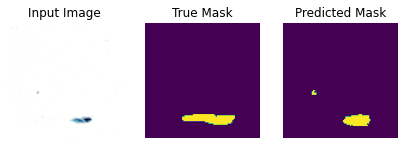


Sample Prediction after epoch 1

958/958 [==============================] - 362s 313ms/step - loss: 0.2057 - binary_io_u: 0.6656 - val_loss: 0.2166 - val_binary_io_u: 0.6940
Epoch 2/50
958/958 [==============================] - ETA: 0s - loss: 0.1177 - binary_io_u: 0.7501

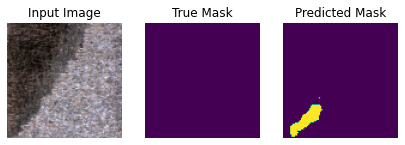


Sample Prediction after epoch 2

958/958 [==============================] - 290s 303ms/step - loss: 0.1177 - binary_io_u: 0.7501 - val_loss: 0.0830 - val_binary_io_u: 0.7362
Epoch 3/50
958/958 [==============================] - ETA: 0s - loss: 0.0930 - binary_io_u: 0.7793

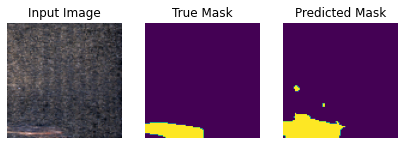


Sample Prediction after epoch 3

958/958 [==============================] - 276s 288ms/step - loss: 0.0930 - binary_io_u: 0.7793 - val_loss: 0.4097 - val_binary_io_u: 0.6529
Epoch 4/50
958/958 [==============================] - ETA: 0s - loss: 0.0915 - binary_io_u: 0.7783

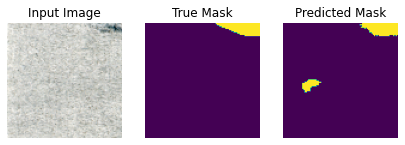


Sample Prediction after epoch 4

958/958 [==============================] - 275s 288ms/step - loss: 0.0915 - binary_io_u: 0.7783 - val_loss: 0.1713 - val_binary_io_u: 0.6705
Epoch 5/50
958/958 [==============================] - ETA: 0s - loss: 0.0697 - binary_io_u: 0.8122

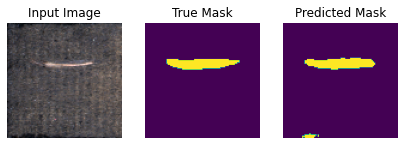


Sample Prediction after epoch 5

958/958 [==============================] - 276s 288ms/step - loss: 0.0697 - binary_io_u: 0.8122 - val_loss: 0.1459 - val_binary_io_u: 0.6737
Epoch 6/50
958/958 [==============================] - ETA: 0s - loss: 0.0624 - binary_io_u: 0.8269

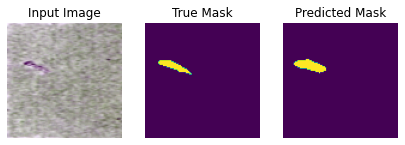


Sample Prediction after epoch 6

958/958 [==============================] - 290s 302ms/step - loss: 0.0624 - binary_io_u: 0.8269 - val_loss: 0.0764 - val_binary_io_u: 0.7731
Epoch 7/50
958/958 [==============================] - ETA: 0s - loss: 0.0584 - binary_io_u: 0.8329

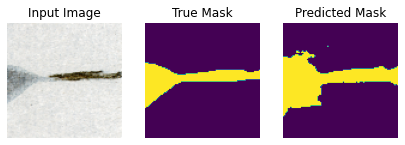


Sample Prediction after epoch 7

958/958 [==============================] - 278s 290ms/step - loss: 0.0584 - binary_io_u: 0.8329 - val_loss: 0.6641 - val_binary_io_u: 0.5137
Epoch 8/50
958/958 [==============================] - ETA: 0s - loss: 0.0499 - binary_io_u: 0.8503

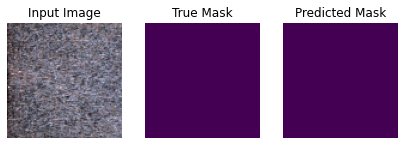


Sample Prediction after epoch 8

958/958 [==============================] - 289s 302ms/step - loss: 0.0499 - binary_io_u: 0.8503 - val_loss: 0.0650 - val_binary_io_u: 0.7606
Epoch 9/50
958/958 [==============================] - ETA: 0s - loss: 0.0395 - binary_io_u: 0.8724

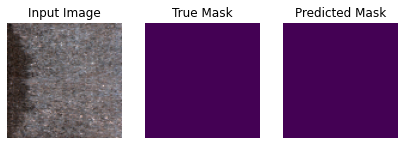


Sample Prediction after epoch 9

958/958 [==============================] - 289s 302ms/step - loss: 0.0395 - binary_io_u: 0.8724 - val_loss: 0.0563 - val_binary_io_u: 0.7783
Epoch 10/50
958/958 [==============================] - ETA: 0s - loss: 0.0361 - binary_io_u: 0.8787

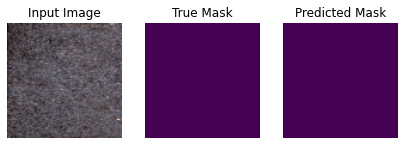


Sample Prediction after epoch 10

958/958 [==============================] - 277s 289ms/step - loss: 0.0361 - binary_io_u: 0.8787 - val_loss: 0.0751 - val_binary_io_u: 0.7678
Epoch 11/50
958/958 [==============================] - ETA: 0s - loss: 0.0324 - binary_io_u: 0.8867

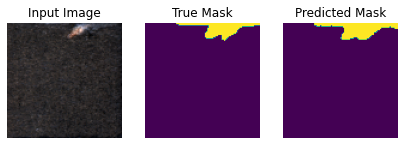


Sample Prediction after epoch 11

958/958 [==============================] - 276s 288ms/step - loss: 0.0324 - binary_io_u: 0.8867 - val_loss: 0.0944 - val_binary_io_u: 0.7485
Epoch 12/50
958/958 [==============================] - ETA: 0s - loss: 0.0292 - binary_io_u: 0.8952

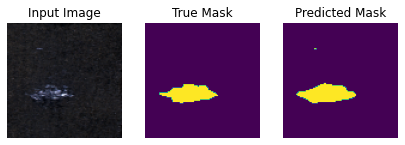


Sample Prediction after epoch 12

958/958 [==============================] - 278s 290ms/step - loss: 0.0292 - binary_io_u: 0.8952 - val_loss: 0.1739 - val_binary_io_u: 0.7643
Epoch 13/50
958/958 [==============================] - ETA: 0s - loss: 0.0248 - binary_io_u: 0.9078

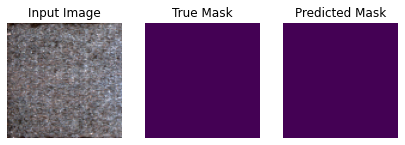


Sample Prediction after epoch 13

958/958 [==============================] - 278s 290ms/step - loss: 0.0248 - binary_io_u: 0.9078 - val_loss: 0.1784 - val_binary_io_u: 0.7192
Epoch 14/50
958/958 [==============================] - ETA: 0s - loss: 0.0216 - binary_io_u: 0.9170

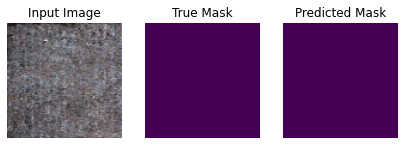


Sample Prediction after epoch 14

958/958 [==============================] - 289s 302ms/step - loss: 0.0216 - binary_io_u: 0.9170 - val_loss: 0.0442 - val_binary_io_u: 0.7968
Epoch 15/50
958/958 [==============================] - ETA: 0s - loss: 0.0213 - binary_io_u: 0.9187

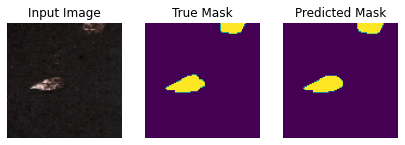


Sample Prediction after epoch 15

958/958 [==============================] - 278s 290ms/step - loss: 0.0213 - binary_io_u: 0.9187 - val_loss: 0.0647 - val_binary_io_u: 0.8026
Epoch 16/50
958/958 [==============================] - ETA: 0s - loss: 0.0204 - binary_io_u: 0.9220

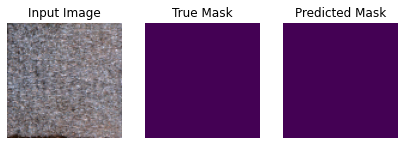


Sample Prediction after epoch 16

958/958 [==============================] - 277s 289ms/step - loss: 0.0204 - binary_io_u: 0.9220 - val_loss: 0.1485 - val_binary_io_u: 0.7814
Epoch 17/50
958/958 [==============================] - ETA: 0s - loss: 0.0186 - binary_io_u: 0.9280

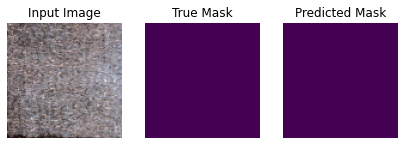


Sample Prediction after epoch 17

958/958 [==============================] - 277s 289ms/step - loss: 0.0186 - binary_io_u: 0.9280 - val_loss: 0.1135 - val_binary_io_u: 0.7927
Epoch 18/50
958/958 [==============================] - ETA: 0s - loss: 0.0173 - binary_io_u: 0.9332

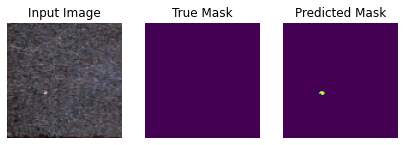


Sample Prediction after epoch 18

958/958 [==============================] - 277s 290ms/step - loss: 0.0173 - binary_io_u: 0.9332 - val_loss: 0.1074 - val_binary_io_u: 0.7403
Epoch 19/50
958/958 [==============================] - ETA: 0s - loss: 0.0136 - binary_io_u: 0.9444

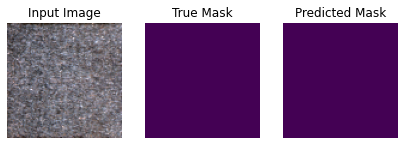


Sample Prediction after epoch 19

958/958 [==============================] - 277s 289ms/step - loss: 0.0136 - binary_io_u: 0.9444 - val_loss: 0.1183 - val_binary_io_u: 0.8148
Epoch 20/50
958/958 [==============================] - ETA: 0s - loss: 0.0172 - binary_io_u: 0.9325

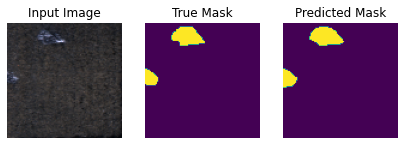


Sample Prediction after epoch 20

958/958 [==============================] - 278s 291ms/step - loss: 0.0172 - binary_io_u: 0.9325 - val_loss: 0.0794 - val_binary_io_u: 0.8021
Epoch 21/50
958/958 [==============================] - ETA: 0s - loss: 0.0127 - binary_io_u: 0.9496

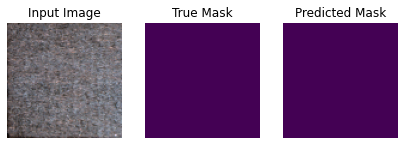


Sample Prediction after epoch 21

958/958 [==============================] - 277s 289ms/step - loss: 0.0127 - binary_io_u: 0.9496 - val_loss: 0.0756 - val_binary_io_u: 0.8185
Epoch 22/50
958/958 [==============================] - ETA: 0s - loss: 0.0125 - binary_io_u: 0.9495

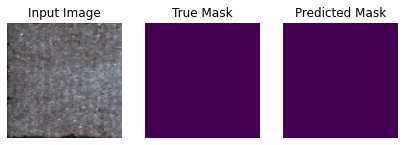


Sample Prediction after epoch 22

958/958 [==============================] - 278s 290ms/step - loss: 0.0125 - binary_io_u: 0.9495 - val_loss: 0.1501 - val_binary_io_u: 0.7698
Epoch 23/50
958/958 [==============================] - ETA: 0s - loss: 0.0129 - binary_io_u: 0.9482

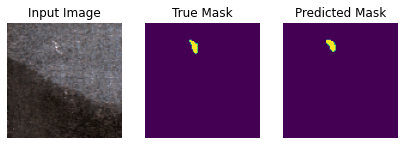


Sample Prediction after epoch 23

958/958 [==============================] - 278s 290ms/step - loss: 0.0129 - binary_io_u: 0.9482 - val_loss: 0.0804 - val_binary_io_u: 0.7849
Epoch 24/50
958/958 [==============================] - ETA: 0s - loss: 0.0112 - binary_io_u: 0.9538

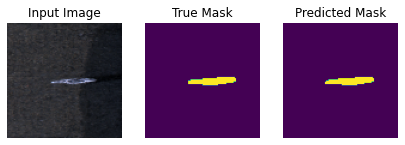


Sample Prediction after epoch 24

958/958 [==============================] - 278s 290ms/step - loss: 0.0112 - binary_io_u: 0.9538 - val_loss: 0.0763 - val_binary_io_u: 0.7784
Epoch 25/50
958/958 [==============================] - ETA: 0s - loss: 0.0153 - binary_io_u: 0.9400

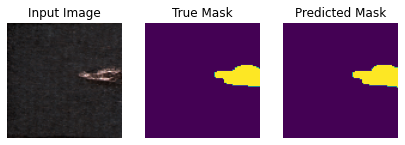


Sample Prediction after epoch 25

958/958 [==============================] - 278s 290ms/step - loss: 0.0153 - binary_io_u: 0.9400 - val_loss: 0.0647 - val_binary_io_u: 0.8114
Epoch 26/50
958/958 [==============================] - ETA: 0s - loss: 0.0086 - binary_io_u: 0.9637

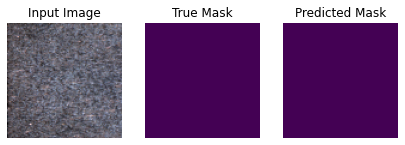


Sample Prediction after epoch 26

958/958 [==============================] - 277s 290ms/step - loss: 0.0086 - binary_io_u: 0.9637 - val_loss: 0.1013 - val_binary_io_u: 0.7714
Epoch 27/50
958/958 [==============================] - ETA: 0s - loss: 0.0092 - binary_io_u: 0.9627

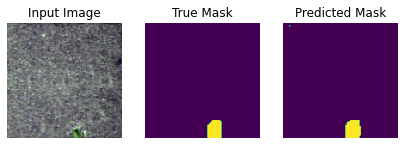


Sample Prediction after epoch 27

958/958 [==============================] - 278s 290ms/step - loss: 0.0092 - binary_io_u: 0.9627 - val_loss: 0.1178 - val_binary_io_u: 0.8068
Epoch 28/50
958/958 [==============================] - ETA: 0s - loss: 0.0107 - binary_io_u: 0.9583

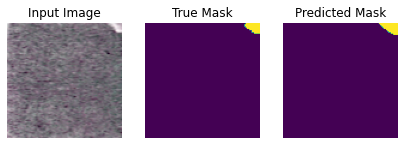


Sample Prediction after epoch 28

958/958 [==============================] - 278s 290ms/step - loss: 0.0107 - binary_io_u: 0.9583 - val_loss: 0.0964 - val_binary_io_u: 0.8129
Epoch 29/50
958/958 [==============================] - ETA: 0s - loss: 0.0134 - binary_io_u: 0.9479

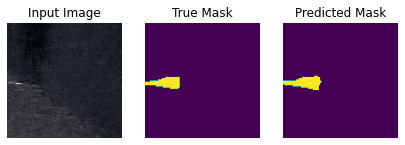


Sample Prediction after epoch 29

958/958 [==============================] - 278s 290ms/step - loss: 0.0134 - binary_io_u: 0.9479 - val_loss: 0.1188 - val_binary_io_u: 0.8050
Epoch 30/50
958/958 [==============================] - ETA: 0s - loss: 0.0073 - binary_io_u: 0.9692

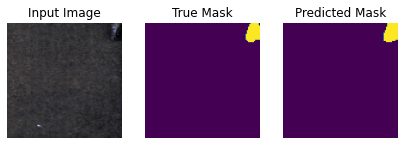


Sample Prediction after epoch 30

958/958 [==============================] - 279s 291ms/step - loss: 0.0073 - binary_io_u: 0.9692 - val_loss: 0.1917 - val_binary_io_u: 0.7749
Epoch 31/50
958/958 [==============================] - ETA: 0s - loss: 0.0078 - binary_io_u: 0.9674

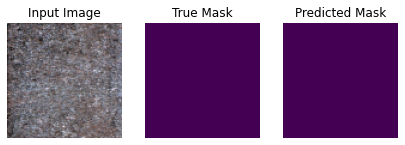


Sample Prediction after epoch 31

958/958 [==============================] - 278s 290ms/step - loss: 0.0078 - binary_io_u: 0.9674 - val_loss: 0.0975 - val_binary_io_u: 0.8269
Epoch 32/50
958/958 [==============================] - ETA: 0s - loss: 0.0076 - binary_io_u: 0.9687

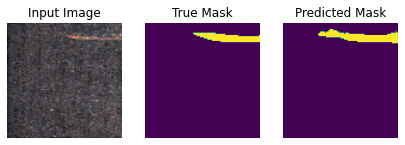


Sample Prediction after epoch 32

958/958 [==============================] - 278s 290ms/step - loss: 0.0076 - binary_io_u: 0.9687 - val_loss: 0.1344 - val_binary_io_u: 0.6867
Epoch 33/50
958/958 [==============================] - ETA: 0s - loss: 0.0109 - binary_io_u: 0.9570

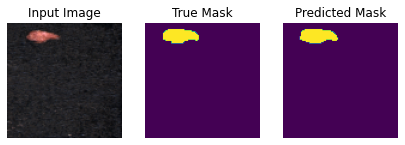


Sample Prediction after epoch 33

958/958 [==============================] - 278s 290ms/step - loss: 0.0109 - binary_io_u: 0.9570 - val_loss: 0.1129 - val_binary_io_u: 0.7405
Epoch 34/50
958/958 [==============================] - ETA: 0s - loss: 0.0071 - binary_io_u: 0.9707

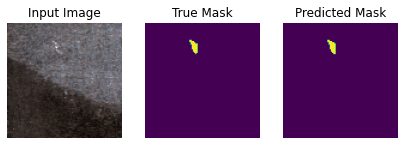


Sample Prediction after epoch 34

958/958 [==============================] - 279s 291ms/step - loss: 0.0071 - binary_io_u: 0.9707 - val_loss: 0.1532 - val_binary_io_u: 0.7768
Epoch 35/50
958/958 [==============================] - ETA: 0s - loss: 0.0054 - binary_io_u: 0.9768

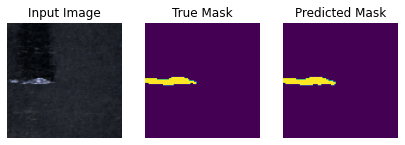


Sample Prediction after epoch 35

958/958 [==============================] - 278s 291ms/step - loss: 0.0054 - binary_io_u: 0.9768 - val_loss: 0.0905 - val_binary_io_u: 0.7846
Epoch 36/50
958/958 [==============================] - ETA: 0s - loss: 0.0105 - binary_io_u: 0.9593

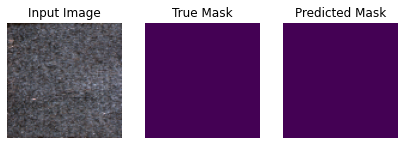


Sample Prediction after epoch 36

958/958 [==============================] - 279s 291ms/step - loss: 0.0105 - binary_io_u: 0.9593 - val_loss: 0.0964 - val_binary_io_u: 0.8162
Epoch 37/50
958/958 [==============================] - ETA: 0s - loss: 0.0078 - binary_io_u: 0.9679

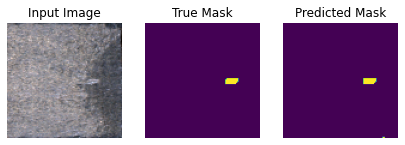


Sample Prediction after epoch 37

958/958 [==============================] - 278s 290ms/step - loss: 0.0078 - binary_io_u: 0.9679 - val_loss: 0.1246 - val_binary_io_u: 0.7933
Epoch 38/50
958/958 [==============================] - ETA: 0s - loss: 0.0075 - binary_io_u: 0.9698

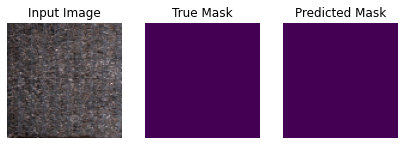


Sample Prediction after epoch 38

958/958 [==============================] - 279s 291ms/step - loss: 0.0075 - binary_io_u: 0.9698 - val_loss: 0.1683 - val_binary_io_u: 0.6941
Epoch 39/50
958/958 [==============================] - ETA: 0s - loss: 0.0070 - binary_io_u: 0.9716

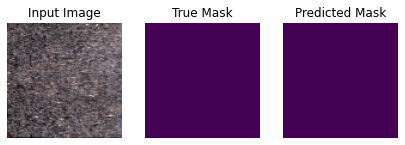


Sample Prediction after epoch 39

958/958 [==============================] - 279s 292ms/step - loss: 0.0070 - binary_io_u: 0.9716 - val_loss: 0.1187 - val_binary_io_u: 0.7491
Epoch 40/50
958/958 [==============================] - ETA: 0s - loss: 0.0053 - binary_io_u: 0.9775

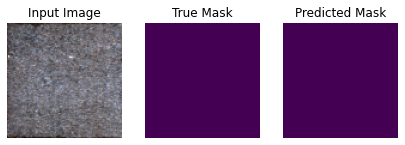


Sample Prediction after epoch 40

958/958 [==============================] - 278s 291ms/step - loss: 0.0053 - binary_io_u: 0.9775 - val_loss: 0.2091 - val_binary_io_u: 0.7701
Epoch 41/50
958/958 [==============================] - ETA: 0s - loss: 0.0054 - binary_io_u: 0.9776

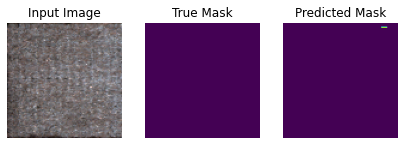


Sample Prediction after epoch 41

958/958 [==============================] - 278s 290ms/step - loss: 0.0054 - binary_io_u: 0.9776 - val_loss: 0.1905 - val_binary_io_u: 0.6244
Epoch 42/50
958/958 [==============================] - ETA: 0s - loss: 0.0061 - binary_io_u: 0.9761

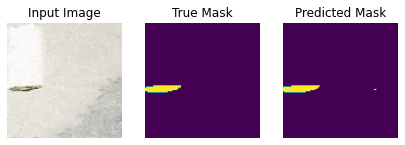


Sample Prediction after epoch 42

958/958 [==============================] - 278s 290ms/step - loss: 0.0061 - binary_io_u: 0.9761 - val_loss: 0.0890 - val_binary_io_u: 0.7791
Epoch 43/50
476/958 [=============>................] - ETA: 2:18 - loss: 0.0115 - binary_io_u: 0.9582

In [ ]:
# model training
VAL_SUBSPLITS = 5
print("[INFO] training model...")
H = model.fit(
    train_generator,
    steps_per_epoch=len(train_images)//BATCH_SIZE,
    validation_data=test_generator,
    validation_steps=len(test_images)//BATCH_SIZE//VAL_SUBSPLITS,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[DisplayCallback(), model_checkpoint_callback])

## CHAPTER 5: MODEL TESTING

#### CONFUSION MATRIX (CM)

In [ ]:
# Confusion Matrix (CM)
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

def plot_confusion_matrix(m, title='Confusion matrix'):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    
    cmap = ListedColormap([[1, 1, 1]])
    img = ax.matshow(m, cmap=cmap)
    plt.title(title)
    
    for (i, j), z in np.ndenumerate(m):
        ax.text(j, i, '{:.0f}'.format(z), ha='center', va='center')
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Background', 'Defective'])
    plt.yticks(tick_marks, ['Background', 'Defective'])
    plt.ylabel('GROUND TRUTH')
    plt.xlabel('PREDICTED')

#### TP/FP/TN/FN & PIXEL ACCURACY (PA) & DICE & INTERSECTION OVER UNION (IoU)

In [ ]:
# TP/FP/TN/FN & Pixel Accuracy (PA) & Intersection Over Union (IoU) & Dice Score
def TP_TN_FP_FN_PA_IOU_DICE(confusion_m, model_name, l=2):
    TP = np.zeros((len(model_name), l))
    TN = np.zeros((len(model_name), l))
    FP = np.zeros((len(model_name), l))
    FN = np.zeros((len(model_name), l))
    
    for index, cm in enumerate(confusion_m):
        TP[index] = np.diag(cm)
        
        for i in range(l):
            temp = np.delete(cm, i, 0)   # delete ith row
            temp = np.delete(temp, i, 1)  # delete ith column
            TN[index][i] = sum(sum(temp))

        for i in range(l):
            FP[index][i] = sum(cm[:,i]) - cm[i,i]

        for i in range(l):
            FN[index][i] = sum(cm[i,:]) - cm[i,i]

    print('                         | ' + model_name[0] + '\t\t\t| ' + model_name[1] + '\t\t| ' + model_name[2] + '\t\t\t| ' + model_name[3] + '\t\t| ' + model_name[4])
    print("*************************|" + '**********************|***********************|***********************|***********************|***********************')
    for i in range(l):
        print("True Positive \t\t |", "{:.2f}".format(TP[0][i]), '\t\t|', "{:.2f}".format(TP[1][i]), '\t\t|', "{:.2f}".format(TP[2][i]), '\t\t|', "{:.2f}".format(TP[3][i]), '\t\t|', "{:.2f}".format(TP[4][i]))
        print("True Negative \t\t |", "{:.2f}".format(TN[0][i]), '\t\t|', "{:.2f}".format(TN[1][i]), '\t\t|', "{:.2f}".format(TN[2][i]), '\t\t|', "{:.2f}".format(TN[3][i]), '\t\t|', "{:.2f}".format(TN[4][i]))
        print("False Positive \t\t |", "{:.2f}".format(FP[0][i]), '\t\t|', "{:.2f}".format(FP[1][i]), '\t\t|', "{:.2f}".format(FP[2][i]), '\t\t|', "{:.2f}".format(FP[3][i]), '\t\t|', "{:.2f}".format(FP[4][i]))
        print("False Negative \t\t |", "{:.2f}".format(FN[0][i]), '\t\t|', "{:.2f}".format(FN[1][i]), '\t\t|', "{:.2f}".format(FN[2][i]), '\t\t|', "{:.2f}".format(FN[3][i]), '\t\t|', "{:.2f}".format(FN[4][i]))
        print("Precision Rate \t\t |", 
             "{:.2f}".format(TP[0][i] / (TP[0][i] + FP[0][i])*100), '\t\t|', 
             "{:.2f}".format(TP[1][i] / (TP[1][i] + FP[1][i])*100), '\t\t|',
             "{:.2f}".format(TP[2][i] / (TP[2][i] + FP[2][i])*100), '\t\t|',
             "{:.2f}".format(TP[3][i] / (TP[3][i] + FP[3][i])*100), '\t\t|',
             "{:.2f}".format(TP[4][i] / (TP[4][i] + FP[4][i])*100))
        print("Recall Rate \t\t |", 
             "{:.2f}".format(TP[0][i] / (TP[0][i] + FN[0][i])*100), '\t\t|', 
             "{:.2f}".format(TP[1][i] / (TP[1][i] + FN[1][i])*100), '\t\t|',
             "{:.2f}".format(TP[2][i] / (TP[2][i] + FN[2][i])*100), '\t\t|',
             "{:.2f}".format(TP[3][i] / (TP[3][i] + FN[3][i])*100), '\t\t|',
             "{:.2f}".format(TP[4][i] / (TP[4][i] + FN[4][i])*100))
        print("Pixel Accuracy \t\t |", 
             "{:.2f}".format((TP[0][i] + TN[0][i]) / (TP[0][i] + TN[0][i] + FP[0][i] + FN[0][i])*100), '\t\t|', 
             "{:.2f}".format((TP[1][i] + TN[1][i]) / (TP[1][i] + TN[1][i] + FP[1][i] + FN[1][i])*100), '\t\t|',
             "{:.2f}".format((TP[2][i] + TN[2][i]) / (TP[2][i] + TN[2][i] + FP[2][i] + FN[2][i])*100), '\t\t|',
             "{:.2f}".format((TP[3][i] + TN[3][i]) / (TP[3][i] + TN[3][i] + FP[3][i] + FN[3][i])*100), '\t\t|',
             "{:.2f}".format((TP[4][i] + TN[4][i]) / (TP[4][i] + TN[4][i] + FP[4][i] + FN[4][i])*100))
        print("Intersection Over Union  |", 
             "{:.2f}".format((TP[0][i]) / (TP[0][i] + FP[0][i] + FN[0][i])*100), '\t\t|', 
             "{:.2f}".format((TP[1][i]) / (TP[1][i] + FP[1][i] + FN[1][i])*100), '\t\t|',
             "{:.2f}".format((TP[2][i]) / (TP[2][i] + FP[2][i] + FN[2][i])*100), '\t\t|',
             "{:.2f}".format((TP[3][i]) / (TP[3][i] + FP[3][i] + FN[3][i])*100), '\t\t|',
             "{:.2f}".format((TP[4][i]) / (TP[4][i] + FP[4][i] + FN[4][i])*100))
        print("Dice Score \t\t |", 
             "{:.2f}".format((2*TP[0][i]) / (2*TP[0][i] + FP[0][i] + FN[0][i])*100), '\t\t|', 
             "{:.2f}".format((2*TP[1][i]) / (2*TP[1][i] + FP[1][i] + FN[1][i])*100), '\t\t|',
             "{:.2f}".format((2*TP[2][i]) / (2*TP[2][i] + FP[2][i] + FN[2][i])*100), '\t\t|',
             "{:.2f}".format((2*TP[3][i]) / (2*TP[3][i] + FP[3][i] + FN[3][i])*100), '\t\t|',
             "{:.2f}".format((2*TP[4][i]) / (2*TP[4][i] + FP[4][i] + FN[4][i])*100))
        print('------------------------------------------------------------------------------------------------------------------------------------------------')
    print('************************************************************************************************************************************************')

#### MEAN INTERSECTION OVER UNION (IoU)

In [ ]:
from tensorflow.keras.metrics import MeanIoU
def mean_IOU(y_true, y_pred, smooth=0.001):
    #             ∥ A ∩ B ∥ 
    # IoU(A,B)  = --------- 
    #             ∥ A ∪ B ∥
    
    #               2 ∥ A ∩ B ∥ 
    # Dice(A,B) = -------------
    #             ∥ A ∥ + ∥ B ∥ 
    
    m = MeanIoU(num_classes=2)
    m.update_state(y_true, y_pred)
    mean_iou = m.result().numpy()
    
    return mean_iou

#### DISPLAY PREDICTION SAMPLE

In [ ]:
def show_prediction_sample(img, label, predict, length=15):
    for i in range(length):
        display([img[i], label[i], predict[i]])

#### ... START EVALUATION ON TEST SET ...

In [ ]:
from tensorflow.keras.models import Sequential, load_model
UNET = load_model('SEMANTIC_SEGMENTATION_KOLEKTORSDD2_T4791_B2085_D2706_UNET.h5', 
                  custom_objects = {"AdamW": tfa.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY),
                                    "mean_iou": mean_iou})
DDUNET = load_model('SEMANTIC_SEGMENTATION_KOLEKTORSDD2_T4791_B2085_D2706_DOUBLEUNET.h5', 
                    custom_objects = {"AdamW": tfa.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY),
                                      "mean_iou": mean_iou})
SETR = load_model('SEMANTIC_SEGMENTATION_KOLEKTORSDD2_T4791_B2085_D2706_SETR.h5', 
                  custom_objects = {'MultiHeadSelfAttention': MultiHeadSelfAttention, 
                                    'TransformerBlock': TransformerBlock,
                                    "AdamW": tfa.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY),
                                    "mean_iou": mean_iou})
TRANSUNET = load_model('SEMANTIC_SEGMENTATION_KOLEKTORSDD2_T4791_B2085_D2706_TRANSUNET.h5', 
                       custom_objects = {'MultiHeadSelfAttention': MultiHeadSelfAttention, 
                                         'TransformerBlock': TransformerBlock,
                                         "AdamW": tfa.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)})
TRANSDAUNET = load_model('SEMANTIC_SEGMENTATION_KOLEKTORSDD2_T4791_B2085_D2706_TRANSDAUNET.h5', 
                         custom_objects = {'MultiHeadSelfAttention': MultiHeadSelfAttention, 
                                           'TransformerBlock': TransformerBlock,
                                           "AdamW": tfa.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=WEIGHT_DECAY)})

In [ ]:
# Ground Truth vs Models Prediction
y_true_train = test_masks
y_true_train_flatten = y_true_train.flatten().astype('int')

y_pred_train_UNET = UNET.predict(test_images)
y_pred_train_UNET = tensorflow.cast((y_pred_train_UNET > 0.5), tensorflow.int64)
y_pred_train_UNET_flatten = y_pred_train_UNET.numpy().flatten().astype('int')

y_pred_train_DDUNET = DDUNET.predict(test_images)
y_pred_train_DDUNET = tensorflow.cast((y_pred_train_DDUNET > 0.5), tensorflow.int64)
y_pred_train_DDUNET_flatten = y_pred_train_DDUNET.numpy().flatten().astype('int')

y_pred_train_SETR = SETR.predict(test_images)
y_pred_train_SETR = tensorflow.cast((y_pred_train_SETR > 0.5), tensorflow.int64)
y_pred_train_SETR_flatten = y_pred_train_SETR.numpy().flatten().astype('int')

y_pred_train_TRANSUNET = TRANSUNET.predict(test_images)
y_pred_train_TRANSUNET = tensorflow.cast((y_pred_train_TRANSUNET > 0.5), tensorflow.int64)
y_pred_train_TRANSUNET_flatten = y_pred_train_TRANSUNET.numpy().flatten().astype('int')

y_pred_train_TRANSDAUNET = TRANSDAUNET.predict(test_images)
y_pred_train_TRANSDAUNET = tensorflow.cast((y_pred_train_TRANSDAUNET > 0.5), tensorflow.int64)
y_pred_train_TRANSDAUNET_flatten = y_pred_train_TRANSDAUNET.numpy().flatten().astype('int')

In [ ]:
# generate confusion_matrix
UNET_train_cm = confusion_matrix(y_true_train_flatten, y_pred_train_UNET_flatten)
DDUNET_train_cm = confusion_matrix(y_true_train_flatten, y_pred_train_DDUNET_flatten)
SETR_train_cm = confusion_matrix(y_true_train_flatten, y_pred_train_SETR_flatten)
TRANSUNET_train_cm = confusion_matrix(y_true_train_flatten, y_pred_train_TRANSUNET_flatten)
TRANSDAUNET_train_cm = confusion_matrix(y_true_train_flatten, y_pred_train_TRANSDAUNET_flatten)

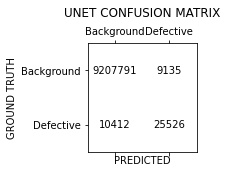

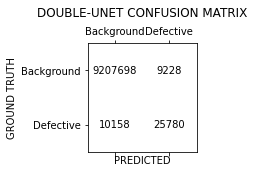

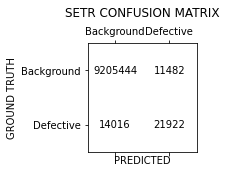

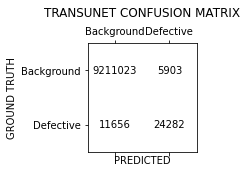

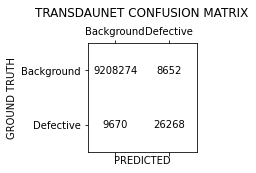

In [ ]:
# CM
plot_confusion_matrix(UNET_train_cm, title='UNET CONFUSION MATRIX\n')
plot_confusion_matrix(DDUNET_train_cm, title='DOUBLE-UNET CONFUSION MATRIX\n')
plot_confusion_matrix(SETR_train_cm, title='SETR CONFUSION MATRIX\n')
plot_confusion_matrix(TRANSUNET_train_cm, title='TRANSUNET CONFUSION MATRIX\n')
plot_confusion_matrix(TRANSDAUNET_train_cm, title='TRANSDAUNET CONFUSION MATRIX\n')

In [ ]:
# PA_IOU
# TP_TN_FP_FN_PA_IOU_DICE([FCN_train_cm, DNET_train_cm, UNET_train_cm, MDDUNET_train_cm, SETR_train_cm, TRANSUNET_train_cm, TRANSDAUNET_train_cm], ["FCN", "DNET", "UNET", "DOUBLEUNET", "SETR", "TRANSUNET", "TRANSDAUNET"])
TP_TN_FP_FN_PA_IOU_DICE([UNET_train_cm, DDUNET_train_cm, SETR_train_cm, TRANSUNET_train_cm, TRANSDAUNET_train_cm], ["UNET", "DOUBLEUNET", "SETR", "TRANSUNET", "TRANSDAUNET"])

                         | UNET			| DOUBLEUNET		| SETR			| TRANSUNET		| TRANSDAUNET
*************************|**********************|***********************|***********************|***********************|***********************
True Positive 		 | 9207791.00 		| 9207698.00 		| 9205444.00 		| 9211023.00 		| 9208274.00
True Negative 		 | 25526.00 		| 25780.00 		| 21922.00 		| 24282.00 		| 26268.00
False Positive 		 | 10412.00 		| 10158.00 		| 14016.00 		| 11656.00 		| 9670.00
False Negative 		 | 9135.00 		| 9228.00 		| 11482.00 		| 5903.00 		| 8652.00
Precision Rate 		 | 99.89 		| 99.89 		| 99.85 		| 99.87 		| 99.90
Recall Rate 		 | 99.90 		| 99.90 		| 99.88 		| 99.94 		| 99.91
Pixel Accuracy 		 | 99.79 		| 99.79 		| 99.72 		| 99.81 		| 99.80
Intersection Over Union  | 99.79 		| 99.79 		| 99.72 		| 99.81 		| 99.80
Dice Score 		 | 99.89 		| 99.89 		| 99.86 		| 99.90 		| 99.90
------------------------------------------------------------------------------------------------------------------

In [ ]:
mean_IoU_score_train_UNET = mean_IOU(y_true_train_flatten, y_pred_train_UNET_flatten)
mean_IoU_score_train_DDUNET = mean_IOU(y_true_train_flatten, y_pred_train_DDUNET_flatten)
mean_IoU_score_train_SETR = mean_IOU(y_true_train_flatten, y_pred_train_SETR_flatten)
mean_IoU_score_train_TRANSUNET = mean_IOU(y_true_train_flatten, y_pred_train_TRANSUNET_flatten)
mean_IoU_score_train_TRANSDAUNET = mean_IOU(y_true_train_flatten, y_pred_train_TRANSDAUNET_flatten)

print('                         | ' + "UNET" + '\t\t | ' + "DOUBLEUNET" + '\t | ' + "SETR" + '\t\t | ' + "TRANSUNET" + '\t | ' + "TRANSDAUNET")
print("*************************|" + '***************|***************|***************|***************|***************')
print("Intersection over Union :| " + 
     "{:.2f}".format(mean_IoU_score_train_UNET*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_train_DDUNET*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_train_SETR*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_train_TRANSUNET*100) + "\t | " +
     "{:.2f}".format(mean_IoU_score_train_TRANSDAUNET*100))
print("*************************|" + '***************|***************|***************|***************|***************')

                         | UNET		 | DOUBLEUNET	 | SETR		 | TRANSUNET	 | TRANSDAUNET
*************************|***************|***************|***************|***************|***************
Intersection over Union :| 78.21	 | 78.43	 | 72.98	 | 78.92	 | 79.36
*************************|***************|***************|***************|***************|***************


## EXTRA: DEMO

Sample images: 
0.   **Background** - 10000
1.   **Defective** - 10021

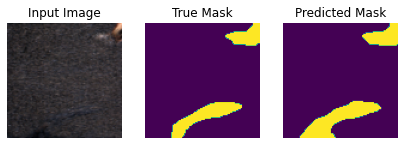

Inference time: 0.5165181249999478 s


In [ ]:
# UNET
start = time.perf_counter()

image = cv2.imread("/content/KolektorSDD2 - T4791 - B2085 - D2706/train/22282.png")
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = cv2.imread("/content/KolektorSDD2 - T4791 - B2085 - D2706/train/22282_GT.png", 0)
mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = (mask > 0).astype(bool)
image = image[np.newaxis, ...]
mask_iou = mask[np.newaxis, ..., np.newaxis]

datagen = ImageDataGenerator()
datagen.fit(image, augment=False)
generator = datagen.flow(x=image, y=mask_iou, batch_size=1)

show_prediction_sample(image, mask_iou, tensorflow.cast((UNET.predict(image) > 0.5), tensorflow.int64), 1)

end = time.perf_counter()
print("Inference time:", end - start, "s")

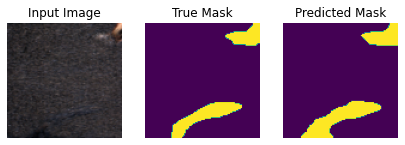

Inference time: 0.4610617739999725 s


In [ ]:
# DOUBLE U-NET
start = time.perf_counter()

image = cv2.imread("/content/KolektorSDD2 - T4791 - B2085 - D2706/train/22282.png")
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = cv2.imread("/content/KolektorSDD2 - T4791 - B2085 - D2706/train/22282_GT.png", 0)
mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = (mask > 0).astype(bool)
image = image[np.newaxis, ...]
mask_iou = mask[np.newaxis, ..., np.newaxis]

datagen = ImageDataGenerator()
datagen.fit(image, augment=False)
generator = datagen.flow(x=image, y=mask_iou, batch_size=1)

show_prediction_sample(image, mask_iou, tensorflow.cast((DDUNET.predict(image) > 0.5), tensorflow.int64), 1)

end = time.perf_counter()
print("Inference time:", end - start, "s")

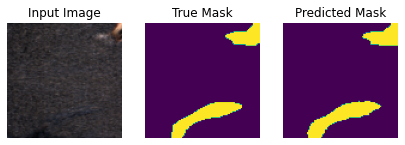

Inference time: 0.5285129100000177 s


In [ ]:
# SETR
start = time.perf_counter()

image = cv2.imread("/content/KolektorSDD2 - T4791 - B2085 - D2706/train/22282.png")
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = cv2.imread("/content/KolektorSDD2 - T4791 - B2085 - D2706/train/22282_GT.png", 0)
mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = (mask > 0).astype(bool)
image = image[np.newaxis, ...]
mask_iou = mask[np.newaxis, ..., np.newaxis]

datagen = ImageDataGenerator()
datagen.fit(image, augment=False)
generator = datagen.flow(x=image, y=mask_iou, batch_size=1)

show_prediction_sample(image, mask_iou, tensorflow.cast((SETR.predict(image) > 0.5), tensorflow.int64), 1)

end = time.perf_counter()
print("Inference time:", end - start, "s")

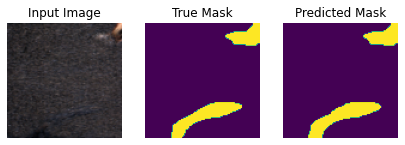

Inference time: 0.428987611000025 s


In [ ]:
# TRANSU-NET
start = time.perf_counter()

image = cv2.imread("/content/KolektorSDD2 - T4791 - B2085 - D2706/train/22282.png")
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = cv2.imread("/content/KolektorSDD2 - T4791 - B2085 - D2706/train/22282_GT.png", 0)
mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = (mask > 0).astype(bool)
image = image[np.newaxis, ...]
mask_iou = mask[np.newaxis, ..., np.newaxis]

datagen = ImageDataGenerator()
datagen.fit(image, augment=False)
generator = datagen.flow(x=image, y=mask_iou, batch_size=1)

show_prediction_sample(image, mask_iou, tensorflow.cast((TRANSUNET.predict(image) > 0.5), tensorflow.int64), 1)

end = time.perf_counter()
print("Inference time:", end - start, "s")

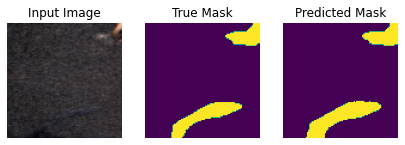

Inference time: 0.3093511770000532 s


In [ ]:
# TRANSDAU-NET
start = time.perf_counter()

image = cv2.imread("/content/KolektorSDD2 - T4791 - B2085 - D2706/train/22282.png")
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = cv2.imread("/content/KolektorSDD2 - T4791 - B2085 - D2706/train/22282_GT.png", 0)
mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA) / 255.
mask = (mask > 0).astype(bool)
image = image[np.newaxis, ...]
mask_iou = mask[np.newaxis, ..., np.newaxis]

datagen = ImageDataGenerator()
datagen.fit(image, augment=False)
generator = datagen.flow(x=image, y=mask_iou, batch_size=1)

show_prediction_sample(image, mask_iou, tensorflow.cast((TRANSDAUNET.predict(image) > 0.5), tensorflow.int64), 1)

end = time.perf_counter()
print("Inference time:", end - start, "s")